In [1]:
import numpy as np
import pandas as pd
import string
import re
from functools import reduce
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns

[Text Summarization with NLTK in Python](https://stackabuse.com/text-summarization-with-nltk-in-python/)

## Overview:

* Convert paragraphs to sentences
* Text preprocessing: remove all the special characters, stop words and numbers from all the sentences
* Tokenizing the sentences
* Find weighted frequency of occurrence: find the weighted frequency of each word by dividing its frequency by the frequency of the most occurring word
* Replace words by weighted frequency in original sentences: plug the weighted frequency in place of the corresponding words in original sentences and find their sum
* Sort sentences in descending order of sum: The sentences with highest frequencies summarize the text

In [2]:
test = "Is this    a test?\n \t(No, it's only a sample.)\n 123, Testing!,  testing...\n"
#test = "President Donald Trump's new trade deal with China will further integrate the world's two largest economies if Beijing honors its commitments in areas ranging from intellectual property protection to agriculture, U.S. Trade Representative Robert Lighthizer said Sunday.\n\n\"Ultimately, whether this whole agreement works is going to be determined by who's making the decisions in China, not in the United States,\" Lighthizer said on CBS News' \"Face the Nation.\" \"If the hardliners are making the decisions, we're going to get one outcome. If the reformers are making the decisions, which is what we hope, then we're going to get another outcome.\"\n\nThe \"phase one\" trade deal announced Friday cancels additional duties that were scheduled to go into effect Sunday, reduces duties on about $120 billion of Chinese goods to 7.5 percent, from 15 percent previously, and leaves a 25 percent duty in place on another $250 billion worth of Chinese goods.\n\nChina, in addition to making promises to better protect U.S. intellectual property, has pledged to buy another $200 billion worth of goods and services from the United States over the next two years, including about $40 billion to $50 billion worth of agricultural products each year.\n\n\"You could think of it as $80 to $100 billion in new sales for agriculture over the course of the next two years. Just massive numbers,\" Lighthizer said.\n\nThat has prompted questions about whether U.S. farmers can actually accommodate the increased demand, without siphoning sales away from other export markets they already have.\n\nFor much of the last two years, there has been a debate about whether Trump's true aim by imposing tariffs on hundreds of billions of dollars of Chinese good was to separate, or \"decouple,\" the U.S. economy from China, rather reach an actual trade agreement.\n\nOn Sunday, Lighthizer indicated the objective was to tie the two economies closer together.\n\n\"The way to think about this deal, is this is a first step in trying to integrate two very different systems to the benefit of both of us,\" the trade chief said.\n\nThe Trump administration also got another trade win last week when House Democrats and the AFL-CIO endorsed a newly revised North American trade agreement with Mexico and Canada, after changes were made to toughen labor enforcement provisions and weaken intellectual property protections for life-saving biologic medicine.\n\nSome of the tweaks made to shore up Democratic support have annoyed Republicans, who have different views of both issues. But that's not expected to block congressional approval. The House is expected to vote on the bill this week and the Senate to follow suit in early 2020, after it finishes Trump's impeachment trial.\n\nLighthizer conceded weakening the biologics provision made the trade deal worse on that point. But he said the overall package was \"better\" as a result of the changes demanded by Democrats.\n\n\"There's nothing about being against labor enforcement that's Republican,\" Lighthizer said. \"The president wants Mexico to enforce its labor laws. He doesn't want American manufacturing workers to have to compete with people who are in very difficult conditions.\""

### paragraph2sentences(text)

Converts a string paragraph into a list of sentences.

In [4]:
def paragraph2sentences(text):
    sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
    text = re.sub("\s+", " ", text.replace(".", ". ").replace(". . . ", "... ")).strip()
    return sent_detector.tokenize(text)

test2 = paragraph2sentences(test)
print(test2)

['Is this a test?', "(No, it's only a sample. )", '123, Testing!, testing...']


### preprocess_sentences(sentence_list)

Removes special characters, stop words and numbers from each sentence in a list of sentences and tokenizes them.

In [5]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words = set(stop_words)

def preprocess_sentences(sentence_list):
    ps = PorterStemmer ()
    lemmatizer = WordNetLemmatizer()
    words = [re.sub("[^a-z\s]+", "", s.lower()).split(" ") for s in sentence_list]
    words = [[lemmatizer.lemmatize(ps.stem(w)) for w in sentence] for sentence in words]
    return [list(set(w) - stop_words - set([''])) for w in words]

test3 = preprocess_sentences(test2)
print(test3)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mjsilva/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[['test', 'thi'], ['onli', 'sampl'], ['test']]


### weighed_freq_occurrence(tokenized_sentence_list)

Divides each word frequency by the frequency of the most occurring word and returns a dictionary with pairs (word, weighted frequency).

In [6]:
def weighed_freq_occurrence(tokenized_sentence_list):
    aux_list = [word for sentence in tokenized_sentence_list for word in sentence]
    aux_list = sorted(aux_list, key=lambda x: aux_list.count(x), reverse=True)
    max_freq = aux_list.count(aux_list[0])
    return {word:aux_list.count(word)/max_freq for word in aux_list}

test4 = weighed_freq_occurrence(test3)
print(test4)

{'test': 1.0, 'thi': 0.5, 'onli': 0.5, 'sampl': 0.5}


### sentence_weighed_freq(tokenized_sentence_list, word_weights)

Replace words in the original sentences by weighted frequency, given by the weights dictionary, and sum.

In [7]:
def sentence_weighed_freq(tokenized_sentence_list, weights):
    aux_list = [[weights[w] if w in weights.keys() else 0 for w in s] for s in tokenized_sentence_list]
    return [sum(s) for s in aux_list]

test5 = sentence_weighed_freq(test3, test4)
print(test5)

[1.5, 1.0, 1.0]


### sort_and_select(sentence_list, sentence_weights, n_sentences)

Given a list of sentences and a list of summed weights per sentence, sort sentences in descending order of weight and select the top n_sentences to generate a string with the text summary.

In [8]:
def sort_and_select(sentence_list, sentence_weights, n_sentences):
    aux_list = list(zip(sentence_list, sentence_weights))
    aux_list = sorted(aux_list, key=lambda x: x[1], reverse=True)
    aux_list = [sentence for sentence,weight in aux_list]
    
    n_sentences = abs(n_sentences)
    if n_sentences<1:
        n_sentences = np.ceil(len(aux_list)*n_sentences)
    if n_sentences>len(aux_list) or n_sentences==0:
        n_sentences = len(aux_list)
    
    return " ".join(aux_list[:int(n_sentences)])

test6 = sort_and_select(test2, test5, 5)
print(test6)

Is this a test? (No, it's only a sample. ) 123, Testing!, testing...


## NLTK SUMMARIZER

Given string `text` and number of sentences `n`, `nltk_summarizer_n` returns a string containing a summary of `text` with either exactly `n` sentences (if the absolute value of `n` is greater than or equal to 1) or `n` percent of the number of sentences in the text (if the absolute value of `n` is a number between 0 and 1; when `n` is 0, the whole text is returned (default is 30% of the number of sentences).

Uses `paragraph2sentences(text)`, `preprocess_sentences(sentence_list)`, `weighed_freq_occurrence(tokenized_sentence_list)`, `sentence_weighed_freq(tokenized_sentence_list, word_weights)` and `sort_and_select(sentence_list, sentence_weights, n_sentences)` functions.

In [9]:
def nltk_summarizer_n(text, n=0.3):
    sentence_list = paragraph2sentences(text)
    tokenized_sentence_list = preprocess_sentences(sentence_list)
    word_weights = weighed_freq_occurrence(tokenized_sentence_list)
    sentence_weights = sentence_weighed_freq(tokenized_sentence_list, word_weights)
    return sort_and_select(sentence_list, sentence_weights, n)

In [10]:
test_summary = nltk_summarizer_n(test, 0.1)
print(test_summary)

Is this a test?


In [11]:
print(test)

Is this    a test?
 	(No, it's only a sample.)
 123, Testing!,  testing...



## Evaluating summarizer using ROUGE-1 and ROUGE-2

### make_bow(text)

Given string text, `make_bow(text)` removes capitalization, punctuation and splits words into a dictionary with the form `{word:count}`.

Uses `clean(text)` function.

In [12]:
# stop_words = set(stop_words)

def make_bow(text):
    ttable = str.maketrans("\n", " ", string.punctuation)
    text = text.replace(".", ". ").translate(ttable).lower()
    text = re.sub("[^a-z\s]", "", text)
    words = re.sub("\s+", " ", text).split(" ")
    words = list(set(words) - stop_words - set(['']))
    return {w:words.count(w) for w in words}

print(make_bow(test))

{'test': 1, 'sample': 1, 'testing': 1}


### get_rouge_score(text_pred, text_real)

Model evaluation metrics. Given an automatically produced summary text_pred, `get_rouge_score` compares the words in it with the words in a second summary, following ROUGE-1. The function returns a tuple with (precision score, recall score, F2 score).

(Note: the function calculates F2 score to give more weight to recall. The size of the two texts will vary, depending on the summarizer parameters, so the level of conciseness of text_pred is not as relevant.)

Uses `make_bow` function.

In [13]:
def get_rouge_score(text_pred, text_real):
    bow_pred = make_bow(text_pred)
    bow_real = make_bow(text_real)
    
    total_pred_words = reduce(lambda x,y: x+bow_pred[y], bow_pred.keys(), 0)
    total_real_words = reduce(lambda x,y: x+bow_real[y], bow_real.keys(), 0)
    
    overlapping_list = [min(bow_pred[k], bow_real[k]) for k in bow_pred.keys() if k in bow_real.keys()]
    overlapping_words = sum(overlapping_list)
    
    precision = overlapping_words/total_pred_words
    recall = overlapping_words/total_real_words
    
    f2_score = 0
    if precision!=0 or recall!=0:
        f2_score = 5 * precision * recall / (4 * precision + recall)
    
    return [precision, recall, f2_score]

print(get_rouge_score(test_summary, test))

[1.0, 0.3333333333333333, 0.3846153846153846]


In [14]:
# ROUGE score using script
%run "resources/rouge-master/rouge/metrics.py"

In [15]:
def tokenize(text):
    sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
    return sent_detector.tokenize(re.sub("\s+", " ", text.replace(".", ". ").replace(". . . ", "... ")).strip())

def score(pred_text, actual_text):
    pred = [s.split() for s in tokenize(pred_text)]
    text = [s.split() for s in tokenize(actual_text)]
    
    _, _, rouge_1 = rouge_n_summary_level(pred, text, 1)
    _, _, rouge_2 = rouge_n_summary_level(pred, text, 2)
    return rouge_1, rouge_2

### Evaluating using TIPSTER test data

In [17]:
df = pd.read_csv("data/tipster_with_predicted_summaries.csv", index_col=0)
df.head()

,abstract,text,abstract_size,pred_summary
0,This paper presents an algorithm for tagging ...,Since online text becomes available in ever i...,3,"For example, verbs taking bare infinitives wer..."
1,The recognition problem for attribute-value g...,Although a universal feature theory does not ...,4,The values of these properties are either atom...
2,Eric Brill introduced transformation-based le...,Text chunking involves dividing sentences int...,5,Bourigault claims that the grammar can parse `...
3,We propose a paradigm for concurrent natural ...,Parallel and distributed computation is expec...,5,We presuppose that two type variables and are ...
4,"We propose an algorithm to resolve anaphors, ...","Intrasentential antecedents, i.e., antecedent...",5,The statistics below show that of 262 non-PRR ...


In [18]:
df["nltk_pred_summary"] = df.apply(lambda x: nltk_summarizer_n(x["text"], x["abstract_size"]), axis=1)
df.head()

,abstract,text,abstract_size,pred_summary,nltk_pred_summary
0,This paper presents an algorithm for tagging ...,Since online text becomes available in ever i...,3,"For example, verbs taking bare infinitives wer...",The left and right context vectors are the bas...
1,The recognition problem for attribute-value g...,Although a universal feature theory does not ...,4,The values of these properties are either atom...,"A CFG is in Greibach normalform (GNF) if, and ..."
2,Eric Brill introduced transformation-based le...,Text chunking involves dividing sentences int...,5,Bourigault claims that the grammar can parse `...,The fact that this system includes lexical rul...
3,We propose a paradigm for concurrent natural ...,Parallel and distributed computation is expec...,5,We presuppose that two type variables and are ...,Suppose that we are required to compose all th...
4,"We propose an algorithm to resolve anaphors, ...","Intrasentential antecedents, i.e., antecedent...",5,The statistics below show that of 262 non-PRR ...,"In the following, remember that what we called..."


In [19]:
df.to_csv("data/tipster_with_predicted_summaries.csv")

In [16]:
df = pd.read_csv("data/tipster_with_predicted_summaries.csv", index_col=0)
df.head()

,abstract,text,abstract_size,pred_summary,nltk_pred_summary
0,This paper presents an algorithm for tagging ...,Since online text becomes available in ever i...,3,"For example, verbs taking bare infinitives wer...",The left and right context vectors are the bas...
1,The recognition problem for attribute-value g...,Although a universal feature theory does not ...,4,The values of these properties are either atom...,"A CFG is in Greibach normalform (GNF) if, and ..."
2,Eric Brill introduced transformation-based le...,Text chunking involves dividing sentences int...,5,Bourigault claims that the grammar can parse `...,The fact that this system includes lexical rul...
3,We propose a paradigm for concurrent natural ...,Parallel and distributed computation is expec...,5,We presuppose that two type variables and are ...,Suppose that we are required to compose all th...
4,"We propose an algorithm to resolve anaphors, ...","Intrasentential antecedents, i.e., antecedent...",5,The statistics below show that of 262 non-PRR ...,"In the following, remember that what we called..."


In [17]:
df["pred_summary_score"] = df.apply(lambda x: score(x["nltk_pred_summary"], x["abstract"]), axis=1)
df["my_pred_summary_score"] = df.apply(lambda x: get_rouge_score(x["nltk_pred_summary"], x["abstract"]), axis=1)
df.head()

,abstract,text,abstract_size,pred_summary,nltk_pred_summary,pred_summary_score,my_pred_summary_score
0,This paper presents an algorithm for tagging ...,Since online text becomes available in ever i...,3,"For example, verbs taking bare infinitives wer...",The left and right context vectors are the bas...,"(0.13438735177865613, 0.0)","[0.1044776119402985, 0.3333333333333333, 0.231..."
1,The recognition problem for attribute-value g...,Although a universal feature theory does not ...,4,The values of these properties are either atom...,"A CFG is in Greibach normalform (GNF) if, and ...","(0.23026315789473686, 0.03973509933774834)","[0.08450704225352113, 0.13636363636363635, 0.1..."
2,Eric Brill introduced transformation-based le...,Text chunking involves dividing sentences int...,5,Bourigault claims that the grammar can parse `...,The fact that this system includes lexical rul...,"(0.2693409742120344, 0.046109510086455335)","[0.1702127659574468, 0.2807017543859649, 0.248..."
3,We propose a paradigm for concurrent natural ...,Parallel and distributed computation is expec...,5,We presuppose that two type variables and are ...,Suppose that we are required to compose all th...,"(0.2051282051282051, 0.022140221402214024)","[0.16304347826086957, 0.3191489361702128, 0.26..."
4,"We propose an algorithm to resolve anaphors, ...","Intrasentential antecedents, i.e., antecedent...",5,The statistics below show that of 262 non-PRR ...,"In the following, remember that what we called...","(0.23272727272727275, 0.029304029304029307)","[0.125, 0.29411764705882354, 0.23148148148148148]"


In [18]:
rouge1 = [a[0] for a in df["pred_summary_score"].values]
rouge2 = [a[1] for a in df["pred_summary_score"].values]

my_precisions = [a[0] for a in df["my_pred_summary_score"].values]
my_recalls = [a[1] for a in df["my_pred_summary_score"].values]
#f2s = [a[2] for a in df["my_pred_summary_score"].values]

x = list(range(len(my_precisions)))

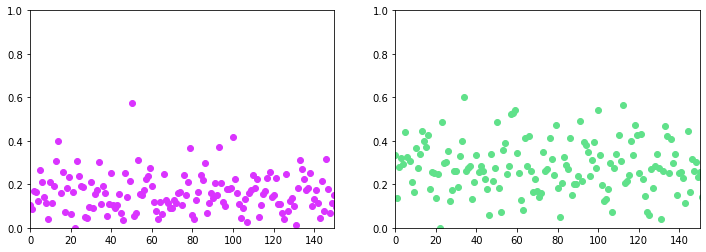

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

#sns.regplot(x2, rouge1_2, scatter=True, ax=axs[0,0])
#sns.regplot(x2, rouge2_2, scatter=True, ax=axs[0,1])

axs[0].scatter(x, my_precisions, color='#da33ff')
axs[0].set_ylim(0,1)
axs[0].set_xlim(0,150)
#axs[0].get_xaxis().set_visible(False)

axs[1].scatter(x, my_recalls, color='#60e18a')
axs[1].set_ylim(0,1)
axs[1].set_xlim(0,150)
#axs[1].get_xaxis().set_visible(False)

#sns.regplot(x2, my_precisions_2, scatter=True, ax=axs[1,0])
#sns.regplot(x2, my_recalls_2, scatter=True, ax=axs[1,1])
#sns.regplot(x2, f2s, scatter=True, ax=axs[2])

plt.savefig("presentation/fa_tipster.png")
plt.show()

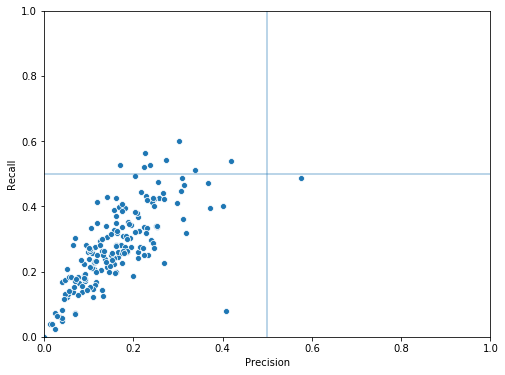

In [31]:
fig, axs = plt.subplots(figsize=(8, 6), sharey=True)
sns.scatterplot(my_precisions, my_recalls, ax=axs)
axs.set(xlabel='Precision', ylabel='Recall')
axs.axhline(0.5, alpha=0.4)  #horizontal line
axs.axvline(0.5, alpha=0.4)  #vertical line
axs.set_xlim(0,1)
axs.set_ylim(0,1)
plt.savefig("presentation/fa_tipster_eval.png", transparency=True)

In [20]:
df[["pred_summary_score", "my_pred_summary_score"]].to_csv("data/tipster_scores.csv")

### Evaluating using BBC NEWS test data

In [33]:
df2 = pd.read_csv("data/bbc_with_predicted_summaries.csv", index_col=0)
df2.head()

,abstract,text,abstract_size,pred_summary,nltk_pred_summary
0,"The messages will be ""unwrapped"" by sculptor R...",Gallery unveils interactive tree\n\nA Christma...,5,"The messages will be ""unwrapped"" by sculptor R...",Gallery unveils interactive tree A Christmas t...
1,Bloom is to be formally presented with the Han...,Jarre joins fairytale celebration\n\nFrench mu...,6,Jarre joins fairytale celebration French music...,Jarre joins fairytale celebration French music...
2,The classic film It's A Wonderful Life is to b...,Musical treatment for Capra film\n\nThe classi...,4,Frank Capra's 1946 movie starring James Stewar...,Musical treatment for Capra film The classic f...
3,"""It was very hard to follow last year's extrem...",Richard and Judy choose top books\n\nThe 10 au...,5,Richard and Judy choose top books The 10 autho...,"""It was very hard to follow last year's extrem..."
4,Mary Poppins was originally created by author ...,Poppins musical gets flying start\n\nThe stage...,4,Lead actress Laura Michelle Kelly soared over ...,Poppins musical gets flying start The stage ad...


In [57]:
df2["nltk_pred_summary"] = df2.apply(lambda x: nltk_summarizer_n(x["text"], x["abstract_size"]), axis=1)
df2.head()

,abstract,text,abstract_size,pred_summary,nltk_pred_summary
0,"The messages will be ""unwrapped"" by sculptor R...",Gallery unveils interactive tree\n\nA Christma...,5,"The messages will be ""unwrapped"" by sculptor R...",Gallery unveils interactive tree A Christmas t...
1,Bloom is to be formally presented with the Han...,Jarre joins fairytale celebration\n\nFrench mu...,6,Jarre joins fairytale celebration French music...,Jarre joins fairytale celebration French music...
2,The classic film It's A Wonderful Life is to b...,Musical treatment for Capra film\n\nThe classi...,4,Frank Capra's 1946 movie starring James Stewar...,Musical treatment for Capra film The classic f...
3,"""It was very hard to follow last year's extrem...",Richard and Judy choose top books\n\nThe 10 au...,5,Richard and Judy choose top books The 10 autho...,"""It was very hard to follow last year's extrem..."
4,Mary Poppins was originally created by author ...,Poppins musical gets flying start\n\nThe stage...,4,Lead actress Laura Michelle Kelly soared over ...,Poppins musical gets flying start The stage ad...


In [58]:
df2.to_csv("data/bbc_with_predicted_summaries.csv")

In [21]:
df2 = pd.read_csv("data/bbc_with_predicted_summaries.csv", index_col=0)
df2.head()

,abstract,text,abstract_size,pred_summary,nltk_pred_summary
0,"The messages will be ""unwrapped"" by sculptor R...",Gallery unveils interactive tree\n\nA Christma...,5,"The messages will be ""unwrapped"" by sculptor R...",Gallery unveils interactive tree A Christmas t...
1,Bloom is to be formally presented with the Han...,Jarre joins fairytale celebration\n\nFrench mu...,6,Jarre joins fairytale celebration French music...,Jarre joins fairytale celebration French music...
2,The classic film It's A Wonderful Life is to b...,Musical treatment for Capra film\n\nThe classi...,4,Frank Capra's 1946 movie starring James Stewar...,Musical treatment for Capra film The classic f...
3,"""It was very hard to follow last year's extrem...",Richard and Judy choose top books\n\nThe 10 au...,5,Richard and Judy choose top books The 10 autho...,"""It was very hard to follow last year's extrem..."
4,Mary Poppins was originally created by author ...,Poppins musical gets flying start\n\nThe stage...,4,Lead actress Laura Michelle Kelly soared over ...,Poppins musical gets flying start The stage ad...


In [22]:
df2["pred_summary_score"] = df2.apply(lambda x: score(x["nltk_pred_summary"], x["abstract"]), axis=1)
df2["my_pred_summary_score"] = df2.apply(lambda x: get_rouge_score(x["nltk_pred_summary"], x["abstract"]), axis=1)
df2.head()

,abstract,text,abstract_size,pred_summary,nltk_pred_summary,pred_summary_score,my_pred_summary_score
0,"The messages will be ""unwrapped"" by sculptor R...",Gallery unveils interactive tree\n\nA Christma...,5,"The messages will be ""unwrapped"" by sculptor R...",Gallery unveils interactive tree A Christmas t...,"(0.8307692307692308, 0.7875647668393783)","[0.7906976744186046, 0.85, 0.8374384236453202]"
1,Bloom is to be formally presented with the Han...,Jarre joins fairytale celebration\n\nFrench mu...,6,Jarre joins fairytale celebration French music...,Jarre joins fairytale celebration French music...,"(0.8325791855203619, 0.7853881278538813)","[0.7611940298507462, 0.8947368421052632, 0.864..."
2,The classic film It's A Wonderful Life is to b...,Musical treatment for Capra film\n\nThe classi...,4,Frank Capra's 1946 movie starring James Stewar...,Musical treatment for Capra film The classic f...,"(0.8216216216216216, 0.7868852459016394)","[0.7857142857142857, 0.868421052631579, 0.8505..."
3,"""It was very hard to follow last year's extrem...",Richard and Judy choose top books\n\nThe 10 au...,5,Richard and Judy choose top books The 10 autho...,"""It was very hard to follow last year's extrem...","(0.853658536585366, 0.8278688524590164)","[0.7936507936507936, 0.8928571428571429, 0.871..."
4,Mary Poppins was originally created by author ...,Poppins musical gets flying start\n\nThe stage...,4,Lead actress Laura Michelle Kelly soared over ...,Poppins musical gets flying start The stage ad...,"(0.9707602339181286, 0.9349112426035503)","[0.9347826086956522, 1.0, 0.9862385321100916]"


In [23]:
rouge1_2 = [a[0] for a in df2["pred_summary_score"].values]
rouge2_2 = [a[1] for a in df2["pred_summary_score"].values]

my_precisions_2 = [a[0] for a in df2["my_pred_summary_score"].values]
my_recalls_2 = [a[1] for a in df2["my_pred_summary_score"].values]
#f2s = [a[2] for a in df2["my_pred_summary_score"].values]

x2 = list(range(len(my_precisions_2)))

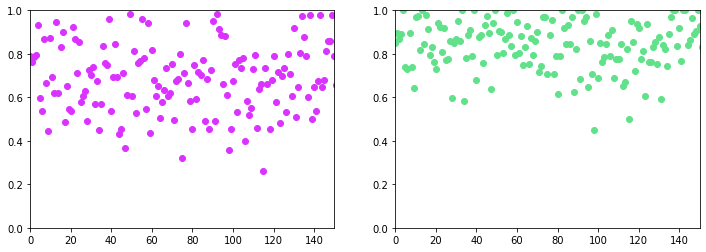

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

#sns.regplot(x2, rouge1_2, scatter=True, ax=axs[0,0])
#sns.regplot(x2, rouge2_2, scatter=True, ax=axs[0,1])

axs[0].scatter(x2, my_precisions_2, color='#da33ff')
axs[0].set_ylim(0,1)
axs[0].set_xlim(0,150)
#axs[0].get_xaxis().set_visible(False)

axs[1].scatter(x2, my_recalls_2, color='#60e18a')
axs[1].set_ylim(0,1)
axs[1].set_xlim(0,150)
#axs[1].get_xaxis().set_visible(False)

#sns.regplot(x2, my_precisions_2, scatter=True, ax=axs[1,0])
#sns.regplot(x2, my_recalls_2, scatter=True, ax=axs[1,1])
#sns.regplot(x2, f2s, scatter=True, ax=axs[2])

plt.savefig("presentation/fa_bbc.png")
plt.show()

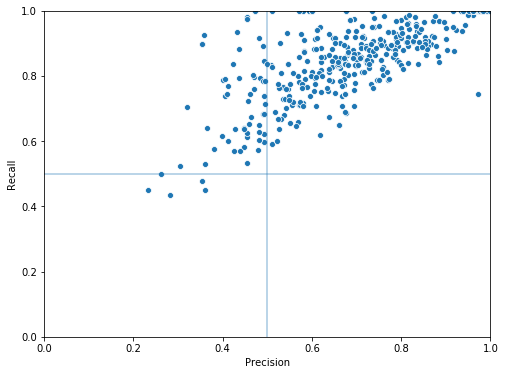

In [37]:
fig, axs = plt.subplots(figsize=(8, 6), sharey=True)
sns.scatterplot(my_precisions_2, my_recalls_2, ax=axs)
axs.set(xlabel='Precision', ylabel='Recall')
axs.axhline(0.5, alpha=0.4)  #horizontal line
axs.axvline(0.5, alpha=0.4)  #vertical line
axs.set_xlim(0,1)
axs.set_ylim(0,1)
plt.savefig("presentation/fa_bbc_eval.png", transparency=True)

In [25]:
df2[["pred_summary_score", "my_pred_summary_score"]].to_csv("data/bbc_scores.csv")

In [98]:
print(df2["abstract"][9], "\n\n\n", df2["nltk_pred_summary"][9], "\n\n\n", df2["pred_summary"][9])

She said the play is being produced and performed by Ugandan women and it is not being forced on them.But the organisers of the play say it raises awareness of sexual abuse against women."The play promotes illegal, unnatural sexual acts, homosexuality and prostitution, it should be and is hereby banned," the council's ruling said.Uganda's authorities have banned the play The Vagina Monologues, due to open in the capital, Kampala this weekend.The four Ugandan NGOs organising the play intended to raise money to campaign to stop violence against women and to raise funds for the war-torn north of the country."There is obviously some fear of the vagina and saying the word vagina," Ms Ensler told the BBC. 


 "I'm amazed that this country Uganda gives the impression that it is progressive and supports women's rights and the notions of free speech; yet when women want to share their stories the government uses the apparatus of state to shut us up. " The four Ugandan NGOs organising the play i

### Evaluating using NEWS SUMMARY (KAGGLE) test data

In [23]:
df3 = pd.read_csv("data/kaggle_with_predicted_summaries.csv", index_col=0)
df3.head()

,text,abstract,abstract_size,pred_summary
3344,India's only existing steam engine was put on ...,"A shiny, sleek white steam engine huffing and ...",16,India's only existing steam engine was put on ...
3080,A producer filed a petition claiming the title...,A court on Thursday sought the response of sup...,25,A producer filed a petition claiming the title...
858,Television actor Karan Wahi has slammed the se...,Television actor Karan Wahi has expressed his ...,47,Television actor Karan Wahi has slammed the se...
227,Twenty-nine Indian cities and towns including ...,"Twenty-nine Indian cities and towns, including...",22,Twenty-nine Indian cities and towns including ...
177,The Gorkha Janmukti Morcha (GJM) has given the...,The Gorkha Janamukti Morcha has given a ten-da...,14,The Gorkha Janmukti Morcha (GJM) has given the...


In [24]:
df3["nltk_pred_summary"] = df3.apply(lambda x: nltk_summarizer_n(x["text"], x["abstract_size"]), axis=1)
df3.head()

,text,abstract,abstract_size,pred_summary,nltk_pred_summary
3344,India's only existing steam engine was put on ...,"A shiny, sleek white steam engine huffing and ...",16,India's only existing steam engine was put on ...,India's only existing steam engine was put on ...
3080,A producer filed a petition claiming the title...,A court on Thursday sought the response of sup...,25,A producer filed a petition claiming the title...,"Further, he claimed that the film's title has ..."
858,Television actor Karan Wahi has slammed the se...,Television actor Karan Wahi has expressed his ...,47,Television actor Karan Wahi has slammed the se...,Television actor Karan Wahi has slammed the se...
227,Twenty-nine Indian cities and towns including ...,"Twenty-nine Indian cities and towns, including...",22,Twenty-nine Indian cities and towns including ...,Twenty-nine Indian cities and towns including ...
177,The Gorkha Janmukti Morcha (GJM) has given the...,The Gorkha Janamukti Morcha has given a ten-da...,14,The Gorkha Janmukti Morcha (GJM) has given the...,The Gorkha Janmukti Morcha (GJM) has given the...


In [25]:
df3.to_csv("data/kaggle_with_predicted_summaries.csv")

In [25]:
df3 = pd.read_csv("data/kaggle_with_predicted_summaries.csv", index_col=0)
df3.head()

,text,abstract,abstract_size,pred_summary,nltk_pred_summary
3344,India's only existing steam engine was put on ...,"A shiny, sleek white steam engine huffing and ...",16,India's only existing steam engine was put on ...,India's only existing steam engine was put on ...
3080,A producer filed a petition claiming the title...,A court on Thursday sought the response of sup...,25,A producer filed a petition claiming the title...,"Further, he claimed that the film's title has ..."
858,Television actor Karan Wahi has slammed the se...,Television actor Karan Wahi has expressed his ...,47,Television actor Karan Wahi has slammed the se...,Television actor Karan Wahi has slammed the se...
227,Twenty-nine Indian cities and towns including ...,"Twenty-nine Indian cities and towns, including...",22,Twenty-nine Indian cities and towns including ...,Twenty-nine Indian cities and towns including ...
177,The Gorkha Janmukti Morcha (GJM) has given the...,The Gorkha Janamukti Morcha has given a ten-da...,14,The Gorkha Janmukti Morcha (GJM) has given the...,The Gorkha Janmukti Morcha (GJM) has given the...


In [26]:
df3["pred_summary_score"] = df3.apply(lambda x: score(x["nltk_pred_summary"], x["abstract"]), axis=1)
df3["my_pred_summary_score"] = df3.apply(lambda x: get_rouge_score(x["nltk_pred_summary"], x["abstract"]), axis=1)
df3.head()

,text,abstract,abstract_size,pred_summary,nltk_pred_summary,pred_summary_score,my_pred_summary_score
3344,India's only existing steam engine was put on ...,"A shiny, sleek white steam engine huffing and ...",16,India's only existing steam engine was put on ...,India's only existing steam engine was put on ...,"(0.24571428571428572, 0.11494252873563218)","[0.6666666666666666, 0.15748031496062992, 0.18..."
3080,A producer filed a petition claiming the title...,A court on Thursday sought the response of sup...,25,A producer filed a petition claiming the title...,"Further, he claimed that the film's title has ...","(0.15771812080536915, 0.06734006734006734)","[0.8, 0.12631578947368421, 0.1518987341772152]"
858,Television actor Karan Wahi has slammed the se...,Television actor Karan Wahi has expressed his ...,47,Television actor Karan Wahi has slammed the se...,Television actor Karan Wahi has slammed the se...,"(0.11372064276885044, 0.07434944237918216)","[0.875, 0.11570247933884298, 0.14]"
227,Twenty-nine Indian cities and towns including ...,"Twenty-nine Indian cities and towns, including...",22,Twenty-nine Indian cities and towns including ...,Twenty-nine Indian cities and towns including ...,"(0.20081967213114751, 0.102880658436214)","[0.9696969696969697, 0.1787709497206704, 0.213..."
177,The Gorkha Janmukti Morcha (GJM) has given the...,The Gorkha Janamukti Morcha has given a ten-da...,14,The Gorkha Janmukti Morcha (GJM) has given the...,The Gorkha Janmukti Morcha (GJM) has given the...,"(0.27561837455830385, 0.16370106761565836)","[0.7142857142857143, 0.19801980198019803, 0.23..."


In [27]:
rouge1_3 = [a[0] for a in df3["pred_summary_score"].values]
rouge2_3 = [a[1] for a in df3["pred_summary_score"].values]

my_precisions_3 = [a[0] for a in df3["my_pred_summary_score"].values]
my_recalls_3 = [a[1] for a in df3["my_pred_summary_score"].values]
#f2s_3 = [a[2] for a in df3["my_pred_summary_score"].values]

x2 = list(range(len(my_precisions_3)))

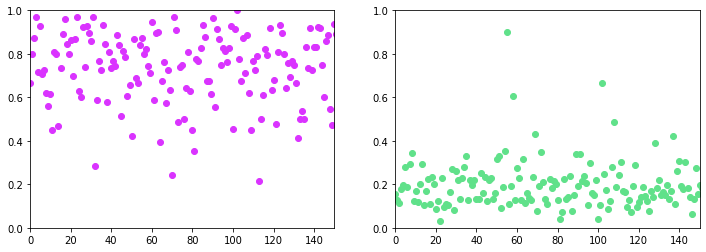

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

#sns.regplot(x2, rouge1_2, scatter=True, ax=axs[0,0])
#sns.regplot(x2, rouge2_2, scatter=True, ax=axs[0,1])

axs[0].scatter(x2, my_precisions_3, color='#da33ff')
axs[0].set_ylim(0,1)
axs[0].set_xlim(0,150)
#axs[0].get_xaxis().set_visible(False)

axs[1].scatter(x2, my_recalls_3, color='#60e18a')
axs[1].set_ylim(0,1)
axs[1].set_xlim(0,150)
#axs[1].get_xaxis().set_visible(False)

#sns.regplot(x2, my_precisions_2, scatter=True, ax=axs[1,0])
#sns.regplot(x2, my_recalls_2, scatter=True, ax=axs[1,1])
#sns.regplot(x2, f2s, scatter=True, ax=axs[2])

plt.savefig("presentation/fa_kaggle.png")
plt.show()

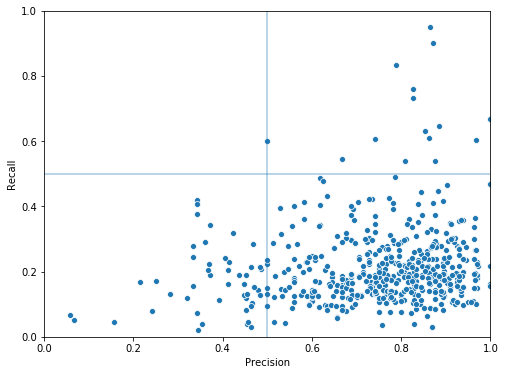

In [43]:
fig, axs = plt.subplots(figsize=(8, 6), sharey=True)
sns.scatterplot(my_precisions_3, my_recalls_3, ax=axs)
axs.set(xlabel='Precision', ylabel='Recall')
axs.axhline(0.5, alpha=0.4)  #horizontal line
axs.axvline(0.5, alpha=0.4)  #vertical line
axs.set_xlim(0,1)
axs.set_ylim(0,1)
plt.savefig("presentation/fa_kaggle_eval.png", transparency=True)

In [30]:
df3[["pred_summary_score", "my_pred_summary_score"]].to_csv("data/kaggle_scores.csv")